In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
# Download daily stock data for AAPL
ticker = "NMR"
start_date = "2023-01-01"
end_date = "2024-12-31"

data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
data.reset_index(inplace=True)
data.head()


C:\Users\aarsh\AppData\Local\Temp\ipykernel_20236\1623916390.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,NMR,NMR,NMR,NMR,NMR
0,2023-01-03,3.77,3.80,3.75,3.80,944900
1,2023-01-04,3.82,3.83,3.78,3.79,1391800
2,2023-01-05,3.74,3.76,3.70,3.74,1014600
3,2023-01-06,3.80,3.81,3.69,3.73,1916600
4,2023-01-09,3.79,3.84,3.78,3.83,523800


In [4]:
print(data.columns)

MultiIndex([(  'Date',    ''),
            ( 'Close', 'NMR'),
            (  'High', 'NMR'),
            (   'Low', 'NMR'),
            (  'Open', 'NMR'),
            ('Volume', 'NMR')],
           names=['Price', 'Ticker'])


In [5]:
# Flatten multi-level columns
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

In [6]:
print(data.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [7]:
data[["Date", "Open", "Close", "High", "Low"]].isna().sum()

Date     0
Open     0
Close    0
High     0
Low      0
dtype: int64

In [8]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
# Price based Features
data["daily_return"] = (data["Close"] - data["Open"]) / data["Open"]

data["price_range"] = (data["High"] - data["Low"]) / data["Open"]

data["volatility"] = data[["Open", "High", "Low", "Close"]].std(axis=1)

data


,Date,Close,High,Low,Open,Volume,daily_return,price_range,volatility
0,2023-01-03,3.77,3.80,3.75,3.80,944900,-0.007895,0.013158,0.024495
1,2023-01-04,3.82,3.83,3.78,3.79,1391800,0.007916,0.013193,0.023805
2,2023-01-05,3.74,3.76,3.70,3.74,1014600,0.000000,0.016043,0.025166
3,2023-01-06,3.80,3.81,3.69,3.73,1916600,0.018767,0.032172,0.057373
4,2023-01-09,3.79,3.84,3.78,3.83,523800,-0.010444,0.015666,0.029439
...,...,...,...,...,...,...,...,...,...
496,2024-12-23,5.77,5.77,5.69,5.69,359100,0.014060,0.014060,0.046188
497,2024-12-24,5.80,5.80,5.76,5.80,205400,0.000000,0.006897,0.020000
498,2024-12-26,5.86,5.88,5.81,5.81,377300,0.008606,0.012048,0.035590
499,2024-12-27,5.86,5.90,5.82,5.89,482500,-0.005093,0.013582,0.035940


In [10]:
# Volume based features
data["volume_change"] = data["Volume"].pct_change()

data["volume_5day_avg"] = data["Volume"].rolling(window=5).mean()
data["volume_vs_avg"] = data["Volume"] / data["volume_5day_avg"]

data

,Date,Close,High,Low,Open,Volume,daily_return,price_range,volatility,volume_change,volume_5day_avg,volume_vs_avg
0,2023-01-03,3.77,3.80,3.75,3.80,944900,-0.007895,0.013158,0.024495,NaN,NaN,NaN
1,2023-01-04,3.82,3.83,3.78,3.79,1391800,0.007916,0.013193,0.023805,0.472960,NaN,NaN
2,2023-01-05,3.74,3.76,3.70,3.74,1014600,0.000000,0.016043,0.025166,-0.271016,NaN,NaN
3,2023-01-06,3.80,3.81,3.69,3.73,1916600,0.018767,0.032172,0.057373,0.889020,NaN,NaN
4,2023-01-09,3.79,3.84,3.78,3.83,523800,-0.010444,0.015666,0.029439,-0.726704,1158340.0,0.452199
...,...,...,...,...,...,...,...,...,...,...,...,...
496,2024-12-23,5.77,5.77,5.69,5.69,359100,0.014060,0.014060,0.046188,-0.158819,453480.0,0.791876
497,2024-12-24,5.80,5.80,5.76,5.80,205400,0.000000,0.006897,0.020000,-0.428014,426200.0,0.481933
498,2024-12-26,5.86,5.88,5.81,5.81,377300,0.008606,0.012048,0.035590,0.836904,395360.0,0.954320
499,2024-12-27,5.86,5.90,5.82,5.89,482500,-0.005093,0.013582,0.035940,0.278823,370240.0,1.303209


In [11]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data


,Date,Close,High,Low,Open,Volume,daily_return,price_range,volatility,volume_change,volume_5day_avg,volume_vs_avg
0,2023-01-09,3.79,3.84,3.78,3.83,523800,-0.010444,0.015666,0.029439,-0.726704,1158340.0,0.452199
1,2023-01-10,3.75,3.76,3.72,3.75,979700,0.000000,0.010667,0.017320,0.870370,1165300.0,0.840728
2,2023-01-11,3.79,3.80,3.77,3.79,758800,0.000000,0.007916,0.012583,-0.225477,1038700.0,0.730529
3,2023-01-12,3.87,3.89,3.81,3.82,765800,0.013089,0.020942,0.038622,0.009225,988940.0,0.774364
4,2023-01-13,3.97,3.97,3.89,3.89,725100,0.020566,0.020566,0.046188,-0.053147,750640.0,0.965976
...,...,...,...,...,...,...,...,...,...,...,...,...
492,2024-12-23,5.77,5.77,5.69,5.69,359100,0.014060,0.014060,0.046188,-0.158819,453480.0,0.791876
493,2024-12-24,5.80,5.80,5.76,5.80,205400,0.000000,0.006897,0.020000,-0.428014,426200.0,0.481933
494,2024-12-26,5.86,5.88,5.81,5.81,377300,0.008606,0.012048,0.035590,0.836904,395360.0,0.954320
495,2024-12-27,5.86,5.90,5.82,5.89,482500,-0.005093,0.013582,0.035940,0.278823,370240.0,1.303209


In [12]:
features = ["daily_return", "price_range", "volatility", "volume_change"]
X = data[features]


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
kmeans = KMeans(n_clusters=5, random_state=42)
data["cluster"] = kmeans.fit_predict(X_scaled)


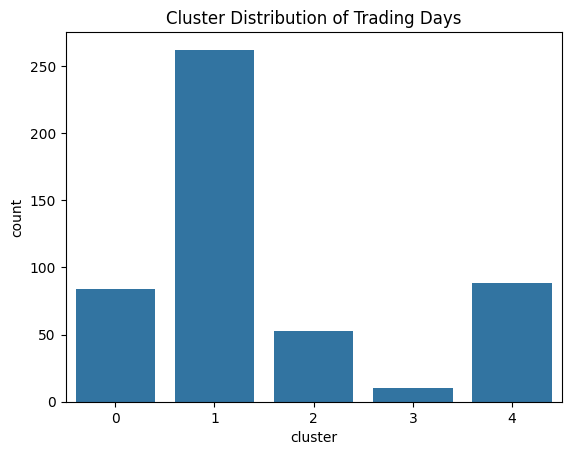

In [15]:
sns.countplot(data=data, x="cluster")
plt.title("Cluster Distribution of Trading Days")
plt.show()


In [16]:
data.groupby("cluster")[features].mean().round(3)


,daily_return,price_range,volatility,volume_change
cluster,,,,
0,0.013,0.021,0.049,0.089
1,0.002,0.011,0.024,-0.091
2,0.000,0.014,0.031,1.250
3,-0.018,0.055,0.135,1.980
4,-0.011,0.018,0.044,0.046


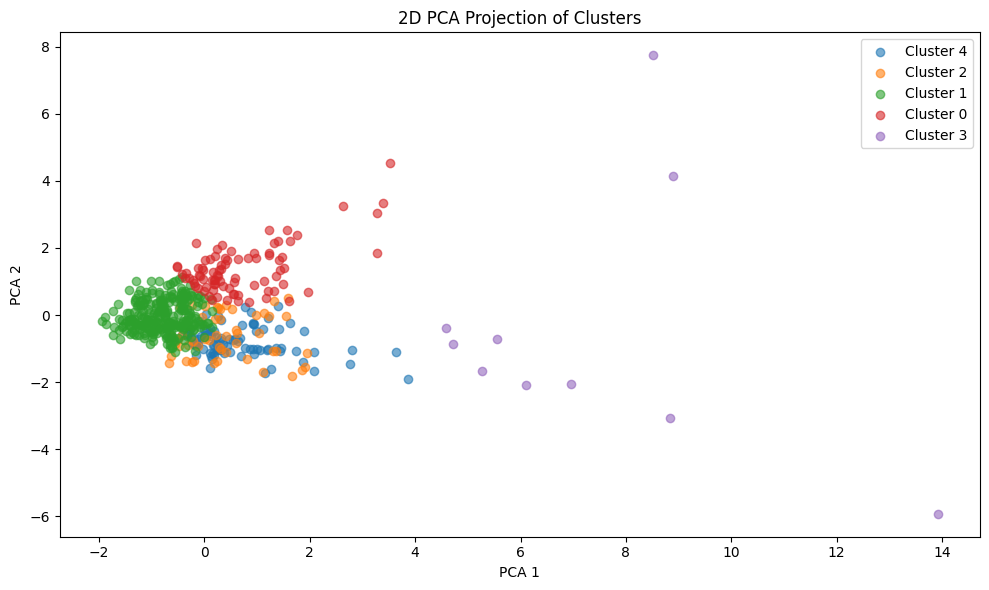

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
for cluster in data["cluster"].unique():
    plt.scatter(X_pca[data["cluster"] == cluster, 0],
                X_pca[data["cluster"] == cluster, 1],
                label=f"Cluster {cluster}", alpha=0.6)

plt.title("2D PCA Projection of Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()


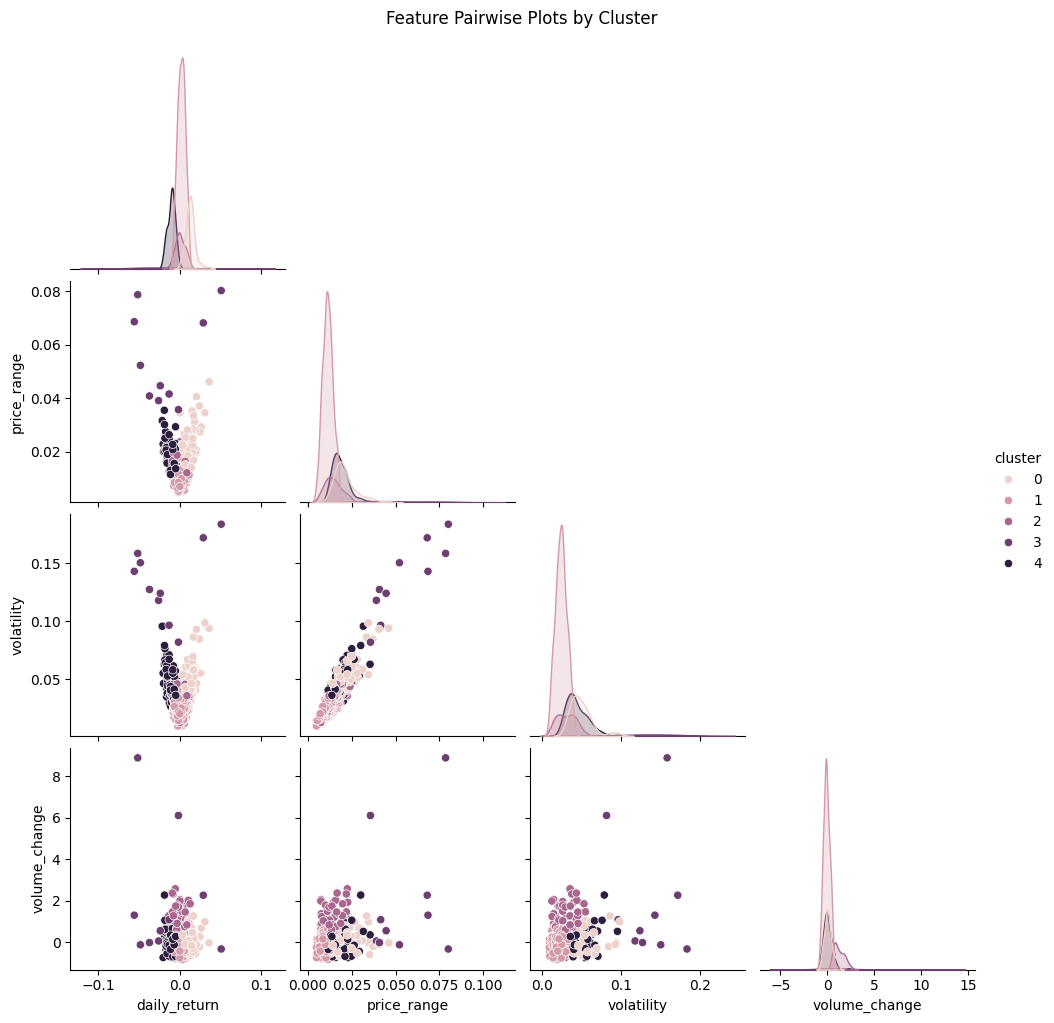

In [18]:
sns.pairplot(data[features + ["cluster"]], hue="cluster", corner=True)
plt.suptitle("Feature Pairwise Plots by Cluster", y=1.02)
plt.show()


,daily_return,price_range,volatility,volume_change
cluster,,,,
0,0.013,0.021,0.049,0.089
1,0.002,0.011,0.024,-0.091
2,0.000,0.014,0.031,1.250
3,-0.018,0.055,0.135,1.980
4,-0.011,0.018,0.044,0.046


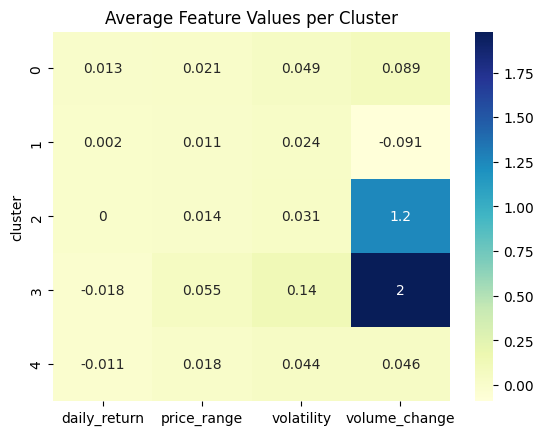

In [19]:
cluster_summary = data.groupby("cluster")[features].mean().round(3)
display(cluster_summary)
sns.heatmap(cluster_summary, annot=True, cmap="YlGnBu")
plt.title("Average Feature Values per Cluster")
plt.show()


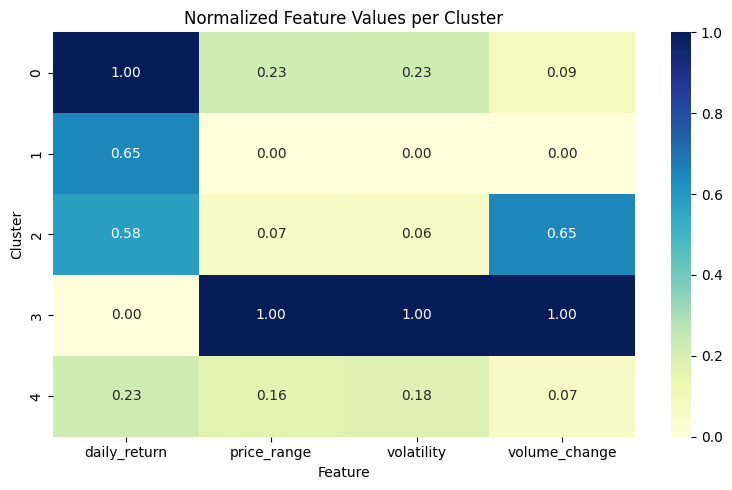

In [20]:
# Normalize the values for visualization (0 to 1 scale)
scaler = MinMaxScaler()
cluster_summary_normalized = pd.DataFrame(
    scaler.fit_transform(cluster_summary),
    columns=cluster_summary.columns,
    index=cluster_summary.index
)

# Plot the normalized heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_summary_normalized, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Normalized Feature Values per Cluster")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()
